# 텐서플로우 튜토리얼#03
# 프리티텐서

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## 경고!

***이 자습서는 FeatTensor builder API가 더 이상 업데이트되지 않고 Google 개발자들에 의해 지원되지 않기 때문에 TensorFlow v. 1.9와 함께 작동하지 않는다. 대신 _Keras API_를 사용하는 것이 좋다. 자습서 #03-C를 참조하십시오.**

## 소개

앞의 튜토리얼에서는 텐서플로우의 작동 방식에 대한 낮은 수준의 지식이 필요한 텐서플로우의 콘볼루션 신경 네트워크를 구현하는 방법을 보여 주었다. 그것은 복잡하고 실수하기 쉬웠다.

이 튜토리얼은 구글이 개발한 프리티텐서라 불리는 텐서플로우(https://github.com/google/prettytensor)의 애드온 패키지 사용법을 보여준다. 프리티텐서는 텐서플로우에서 신경망을 구축하는 훨씬 간단한 방법을 제공하므로 구현하고자 하는 아이디어에 집중할 수 있고 낮은 수준의 구현 세부사항에 대해서는 크게 걱정하지 않아도 된다. 이것은 또한 소스 코드를 훨씬 더 짧고 읽기 쉽고 수정하기 쉽게 만든다.

이 튜토리얼의 소스 코드는 현재 FeattyTensor를 사용하여 수행되는 그래프 구조를 제외하고 자습서 #02와 대부분 동일하며, 그 외 일부 사소한 변경 사항도 예외로 한다.

이 자습서는 자습서 #02에 직접 작성되며 텐서플로우를 처음 접하는 경우 먼저 해당 자습서를 공부하는 것이 좋다. 기본적인 선형대수학, 파이톤과 주피터 공책 에디터에게도 익숙해져야 한다.

## 플로우 차트

다음 도표는 아래에 구현된 컨볼루션 신경망에서 데이터가 어떻게 흐르는지 대략적으로 보여준다. 콘볼루션에 대한 자세한 설명은 이전 자습서를 참조하십시오.

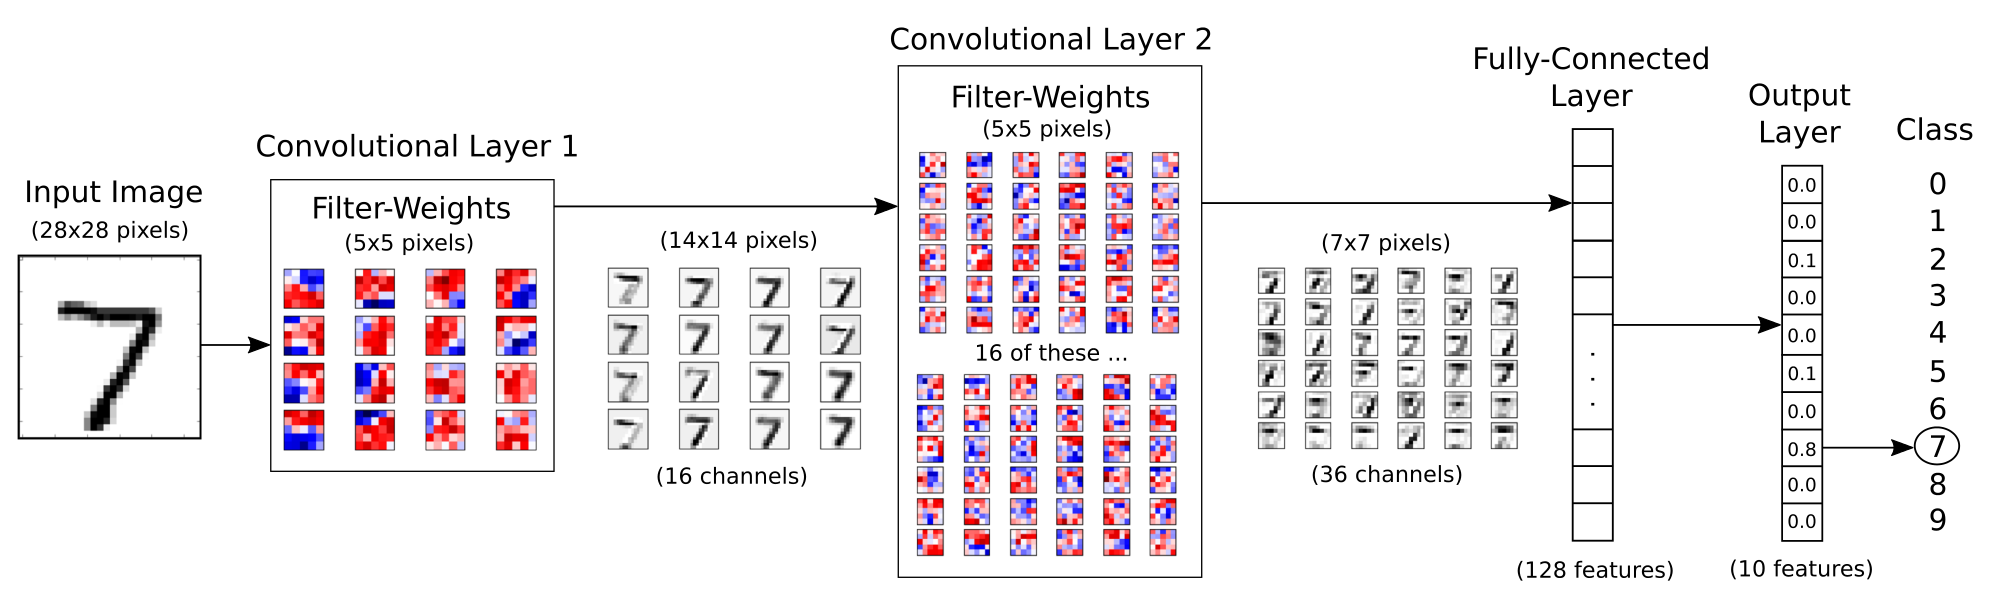

In [1]:
from IPython.display import Image
Image('images/02_network_flowchart.png')

입력 이미지는 필터-가중치를 사용하여 첫 번째 경련층에서 처리된다. 이로 인해 16개의 새로운 이미지가 생성되며, 각 필터마다 한 개의 합성 층이 생성된다. 영상도 하향 샘플링되므로 영상 해상도가 28x28에서 14x14로 감소한다.

이 16개의 작은 이미지들은 두 번째 경련층에서 처리된다. 우리는 이 16개 채널 각각에 대한 필터-가중치가 필요하고, 이 계층의 각 출력 채널에 대한 필터-가중치가 필요하다. 출력 채널은 36개가 있으므로 두 번째 경련층에는 총 16 x 36 = 576개의 필터가 있다. 결과 영상은 7x7 픽셀로 다시 다운샘플링된다.

제2컨벌루션층의 출력은 각각 7x7픽셀의 36개 이미지다. 그리고 나서 이것들은 길이 7 x 7 x 36 = 1764의 단일 벡터로 평평하게 되는데, 이것은 128개의 뉴런(또는 원소)으로 완전히 연결된 층에 대한 입력으로 사용된다. 이것은 10개의 뉴런으로 완전히 연결된 또 다른 층으로 공급되는데, 각 계층마다 하나씩, 즉 영상의 등급을 결정하는 데 사용되는, 즉 영상에 어떤 숫자가 묘사되어 있는가 하는 것이다.

컨벌루션형 필터는 처음에 무작위로 선택되기 때문에 분류는 무작위로 이루어진다. 입력 영상의 예측 클래스와 실제 클래스 사이의 오차는 이른바 교차 엔트로피로 측정된다. 그런 다음 최적기는 분화의 체인 규칙을 사용하여 자동으로 이 오류를 콘볼루션 네트워크를 통해 다시 전파하고 분류 오류를 개선하도록 필터 가중치를 업데이트한다. 이는 분류 오류가 충분히 낮을 때까지 반복적으로 수천 번 이루어진다.

이러한 특정 필터 무게와 중간 이미지는 하나의 최적화 실행의 결과물이며 이 노트북을 다시 실행하면 다르게 보일 수 있다.

TensorFlow의 계산은 실제로 단일 영상 대신 영상 배치에서 수행되므로 계산의 효율성이 향상된다는 점에 유의하십시오. 이는 실제로 TensorFlow에서 구현했을 때 플로우차트가 한 가지 더 데이터 경감을 갖는다는 것을 의미한다.

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

# We also need PrettyTensor.
import prettytensor as pt

ModuleNotFoundError: No module named 'tensorflow'

This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [ ]:
tf.__version__

PrettyTensor version:

In [ ]:
pt.__version__

## 데이터 로드

MNIST 데이터 세트는 약 12MB로 주어진 경로에 위치하지 않으면 자동으로 다운로드된다.

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

MNIST 데이터 세트는 현재 로드되었으며 7만 개의 영상과 관련 라벨(즉, 영상 분류)으로 구성되어 있다. 데이터 세트는 3개의 상호 배타적인 하위 세트로 분할된다. 이번 튜토리얼에서는 훈련과 시험 세트만 사용할 것이라고 말했다.

In [ ]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

클래스 라벨은 One-Hot 인코딩된 것으로, 각 라벨은 10개의 원소를 가진 벡터라는 뜻이며, 한 요소를 제외하고는 모두 0이다. 이 한 요소의 색인은 클래스 번호, 즉 관련 이미지에 표시된 숫자다. 시험 세트의 정수로도 학급번영자가 필요하니까 지금 계산하는 거야.

In [ ]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## 데이터 디멘션

데이터 치수는 아래의 소스 코드의 여러 곳에서 사용된다. 이 변수들은 한 번 정의되기 때문에 우리는 아래의 소스 코드 전체에 걸쳐 숫자 대신 이러한 변수를 사용할 수 있다.

In [ ]:
# 우리는 MNIST 영상이 각 차원에 28픽셀이라는 것을 알고 있다.
img_size = 28

# 이미지는 이 길이의 1차원 배열로 저장된다.
img_size_flat = img_size * img_size

# 배열을 재구성하는 데 사용되는 이미지의 높이와 폭을 가진 튜플.
img_shape = (img_size, img_size)

# 영상의 색상 채널 수: 그레이 스케일의 경우 1 채널.
num_channels = 1

# 클래스 수, 열 자리마다 한 클래스씩.
num_classes = 10

### 이미지 플롯을 위한 도우미 함수

9개의 영상을 3x3 그리드에 플로팅하고 각 이미지 아래에 참 클래스와 예측 클래스를 작성하는 데 사용되는 기능

In [3]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # 3x3 서브플롯으로 피규어를 만든다.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # 플롯 이미지
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # 진실되고 예측된 수업을 보여라.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # x축에 클래스를 라벨로 표시한다.
        ax.set_xlabel(xlabel)
        
        # 플롯에서 눈금을 제거하라.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # 그림이 여러 그림으로 올바르게 표시되는지 확인
    # 단일 노트북 셀에.
    plt.show()

### Plot a few images to see if data is correct

In [4]:
# 시험 세트에서 첫 번째 영상을 얻으십시오.
images = data.test.images[0:9]

# 그 이미지들에 대한 진정한 수업을 받으세요.
cls_true = data.test.cls[0:9]

# 위의 도우미 기능을 사용하여 이미지와 라벨을 플롯하십시오.
plot_images(images=images, cls_true=cls_true)

NameError: name 'data' is not defined

## 텐서플로우 이미지

텐서플로우의 전체 목적은 파이톤에서 직접 동일한 계산을 수행할 경우보다 훨씬 효율적으로 실행할 수 있는 이른바 계산 그래프를 갖추는 것이다. 텐서플로우는 실행해야 하는 전체 연산 그래프를 알고 있는 반면, NumPy는 한 번에 하나의 수학 연산만을 알고 있기 때문에 텐서플로우는 NumPy보다 효율적일 수 있다.

TensorFlow는 모델의 성능을 향상시키기 위해 그래프의 변수를 최적화하는 데 필요한 그라데이션도 자동으로 계산할 수 있다. 이는 그래프가 단순한 수학 식을 조합한 것이어서 전체 그래프의 그라데이션은 파생상품의 체인룰을 이용해 계산할 수 있기 때문이다.

TensorFlow는 GPU뿐만 아니라 멀티 코어 CPU도 활용할 수 있으며 구글은 TPU(Tensor Processing Units)라고 불리며 GPU보다 더 빠른 텐서플로우만을 위한 특수 칩까지 만들었다.

TensorFlow 그래프는 아래에 자세히 설명될 다음과 같은 부분으로 구성된다:

* 그래프로 데이터를 입력하는 데 사용되는 자리 표시자 변수.
* 컨볼루션 네트워크를 더 잘 수행할 수 있도록 최적화될 변수.
* 콘볼루션 네트워크의 수학 공식.
* 변수의 최적화를 안내하는 데 사용할 수 있는 비용 측정값.
* 변수를 업데이트하는 최적화 방법.

또한 TensorFlow 그래프는 본 자습서에서 다루지 않는 TensorBoard를 사용하여 표시되는 데이터 로깅과 같은 다양한 디버깅 문도 포함할 수 있다.

### 플레이스 홀더 변수

플레이스홀더 변수는 우리가 그래프를 실행할 때마다 변경될 수 있는 텐서플로 계산 그래프의 입력 역할을 한다. 우리는 이것을 자리 표시자 변수 공급이라고 부르는데, 그것은 아래에 더 자세히 설명되어 있다.

먼저 우리는 입력 영상에 대한 자리 표시자 변수를 정의한다. 이를 통해 TensorFlow 그래프에 입력되는 영상을 변경할 수 있다. 이것은 단지 다차원 배열이라는 뜻의 이른바 텐서다. 데이터 타입은 `float32`로, 형태는 `[None, img_size_flat]`로 설정되어 있는데, 여기서 `None`은 각각의 이미지가 길이 `img_size_flat`의 벡터인 상태에서 임의의 수의 영상을 담을 수 있다는 것을 의미한다.

In [5]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

NameError: name 'tf' is not defined

콘볼루션층에서는 `x`가 4차원 텐서로 인코딩될 것으로 예상하므로 그 모양이 `[num_images, img_hight, img_width, num_channels]`가 되도록 재구성해야 한다. `img_hight == img_width==img_size`와 `num_images`는 첫 번째 치수 크기에 대해 -1을 사용하여 자동으로 추론할 수 있다. 따라서 재편성 작업은 다음과 같다.

In [6]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

NameError: name 'tf' is not defined

다음에는 자리 표시자 변수 `x`에 입력된 이미지와 관련된 실제 레이블에 대한 자리 표시자 변수가 있다. 이 자리 표시자 변수의 모양은 임의의 수의 레이블을 포함할 수 있다는 뜻의 `[None, num_classes]`이며, 각 레이블은 길이가 10인 `num_classes`의 벡터다.

In [7]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

NameError: name 'tf' is not defined

클래스 번호에 대한 자리 표시자 변수도 가질 수 있지만 대신 argmax를 사용해 계산하겠다. 이 연산자는 텐서플로우 연산자이므로 이 시점에서는 아무것도 계산되지 않는다는 점에 유의하십시오.

In [8]:
y_true_cls = tf.argmax(y_true, dimension=1)

NameError: name 'tf' is not defined

## 텐서플로우 구현

이 절은 콘볼루션 신경 네트워크를 텐서플로에서 직접 구현하는 튜토리얼 #02의 원본 코드를 보여준다. 이 코드는 이 노트북에서 실제로 사용되지 않으며 아래의 FeatTensor 구현과 쉽게 비교할 수 있도록 만들어졌다.

여기 주목해야 할 것은 코드 라인이 몇 개인지와 텐서플로우가 데이터를 저장하고 계산을 수행하는 방법에 대한 낮은 수준의 세부사항이다. 꽤 작은 뉴럴 네트워크에서도 실수하기 쉽다.

### 도움 함수

텐서플로우 직접 구현에서는 먼저 그래프 구성에서 여러 번 사용할 일부 도우미 기능을 만든다.

이 두 함수는 랜덤 값으로 초기화할 텐서플로 그래프에서 새로운 변수를 생성한다.

In [9]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [10]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

다음과 같은 도우미 기능이 새로운 경련 네트워크를 만든다. 입력과 출력은 4차원 텐서(일명 4등급 텐서)이다. 가중치 변수의 모양과 같은 텐서플로 API의 낮은 수준의 세부 사항을 참고하십시오. 어딘가에서 실수하기 쉬워 디버깅하기 어려운 이상한 오류 메시지가 나올 수 있다고 말했다.

In [11]:
def new_conv_layer(input,              # 이전 층
                   num_input_channels, # 이전 층의 채널 수
                   filter_size,        # 필터의 넓이와 높이
                   num_filters,        # 필터의 수
                   use_pooling=True):  # 2X2 맥스 풀링을 사용하라

    # 콘볼루션용 필터-가중치의 모양.
    # 이 형식은 TensorFlow API에 의해 결정된다.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # 지정된 모양으로 새 가중치 aka. 필터 만들기.
    weights = new_weights(shape=shape)

    # 필터별로 하나씩 새 biases 작성.
    biases = new_biases(length=num_filters)

    # Convolution을 위한 TensorFlow 작업 생성.
    # 모든 차원에서 장족의 진보는 1로 설정됨을 유의한다.
    # 첫 번째와 마지막 걸음은 항상 1이어야 한다,
    # 첫 번째는 이미지 번호와 n을 위한 것이기 때문에
    # 마지막은 입력 채널용이다.
    # 그러나 예를 들어, strides =[1, 2, 1]은 필터가
    # 영상의 x축과 y축에 걸쳐 2픽셀 이동된다.
    # 패딩이 입력 이미지를 의미하는 'SAME'로 설정됨
    # 0으로 패딩되어 출력 크기가 동일함
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # 콘볼루션 결과에 biases 추가
    # 각 필터 채널에 바이어스 값이 추가됨.
    layer += biases

    # 이미지 해상도를 낮추기 위해 풀링을 사용하시겠습니까?
    if use_pooling:
        # 이건 2x2 최대 풀링이다. 그 말은 우리가
        # 2x2 윈도우를 고려하고 가장 큰 값을 선택하십시오.
        # 각 창문에 그럼 2픽셀을 다음 창으로 옮기자.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # 각 입력 픽셀 x에 대한 max(x, 0)을 계산한다.
    # 이것은 공식에 비선형성을 더하고 우리를 허용한다.
    # 더 복잡한 기능을 배우기 위해
    layer = tf.nn.relu(layer)

    # ReLU는 일반적으로 풀링 전에 실행된다는 점에 유의하십시오,
    # 그러나 relu(max_pool(x) ==max_pool(relu(x)))이므로 우리는
    # 릴루-트랜스포트의 75%를 먼저 최대값으로 절약한다.

    # 결과 도면층과 필터-가중치를 모두 반환함
    # 왜냐하면 우리는 가중치를 나중에 계획할 것이기 때문이다.
    return layer, weights


다음의 도우미 기능은 4차원 텐서(them tensor)를 2차원(dim)으로 평탄하게 만들어 우리는 경련층 이후에 완전히 연결된 층을 추가할 수 있다.

In [12]:
def flatten_layer(layer):
    # 입력층의 모양을 잡아라.
    layer_shape = layer.get_shape()

    # 입력층의 모양은 다음과 같이 가정한다:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # 피쳐 수는: img_height * img_width * num_channels
    # TensorFlow의 함수를 사용하여 이 값을 계산할 수 있다.
    num_features = layer_shape[1:4].num_elements()

    # 레이어를 [num_images, num_features]로 재구성한다.
    # 두번째 차원\n의 크기를 정했다는 것을 주목하라.
    # num_features 및 첫 번째 치수의 크기
    #치수의 크기가 계산됨을 의미함
    # 따라서 텐서의 전체 크기는 개편에서 변하지 않는다.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # 이제 평평해진 층의 모양이다:
    # [num_images, img_height * img_width * num_channels]

    # 평평해진 층과 형상의 수를 모두 반환한다.
    return layer_flat, num_features

다음의 도우미 함수는 완전히 연결된 레이어를 만든다.

In [13]:
def new_fc_layer(input,          # 이전 층
                 num_inputs,     # 이전 층의 입력 수
                 num_outputs,    # 출력 수
                 use_relu=True): # ReLU를 사용했나?

    # 새로운 가중치와 바이어스을 만들어라.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # 도면층을 행렬의 곱으로 계산
    # 입력과 가중치를 입력한 다음 바이어스-바이어를 추가한다.
    layer = tf.matmul(input, weights) + biases

    # ReLU 사용했니?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### 그래프 구성

지금 콘볼루션 신경 네트워크는 위의 도우미 기능을 사용하여 건설될 겁니다. 조력자 기능이 없었다면 이 작업은 매우 길고 혼란스러울 수 있었을 것이다.

다음 코드는 실제로 실행되지 않는다는 점에 유의하십시오. 아래 PeatTensor 코드와 쉽게 비교할 수 있도록 여기에 표시되었다.

이전의 자습서에서는 다른 곳에서 정의한 상수를 사용하여 쉽게 변경할 수 있었다. 예를 들어 `new_conv_layer()`에 대한 주장으로 `filter_size=5`를 갖는 대신 `filter_size=filter1`을 택한 뒤 다른 곳에서 `filter_size1=5`를 정의했다. 이 때문에 모든 상수를 쉽게 바꿀 수 있었다고 말했다.

In [14]:
if False:  # 이것을 실행하지 마세요! 단지 쉽게 비교하기 위해 보여주는 겁니다.
    # 첫번째 콘볼루션층
    layer_conv1, weights_conv1 = \
        new_conv_layer(input=x_image,
                       num_input_channels=num_channels,
                       filter_size=5,
                       num_filters=16,
                       use_pooling=True)

    # 두번째 콘볼루션층
    layer_conv2, weights_conv2 = \
        new_conv_layer(input=layer_conv1,
                       num_input_channels=16,
                       filter_size=5,
                       num_filters=36,
                       use_pooling=True)

    # 플래튼 층
    layer_flat, num_features = flatten_layer(layer_conv2)

    # 첫번째 완전연결층
    layer_fc1 = new_fc_layer(input=layer_flat,
                             num_inputs=num_features,
                             num_outputs=128,
                             use_relu=True)

    # 두번째 완전연결층
    layer_fc2 = new_fc_layer(input=layer_fc1,
                             num_inputs=128,
                             num_outputs=num_classes,
                             use_relu=False)

    # 예측된 클래스 레이블.
    y_pred = tf.nn.softmax(layer_fc2)

    # 각 영상의 분류를 위한 교차 엔트로피.
    cross_entropy = \
        tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                labels=y_true)

    # 손실 aka. 비용 측정.
    # 최소화해야 할 스칼라 값이다.
    loss = tf.reduce_mean(cross_entropy)

## 프리티텐서 구현

이 절은 Feattensor를 이용한 콘볼루션 신경망의 정확히 동일한 구현을 하는 방법을 보여준다.

기본적인 아이디어는 입력 텐서 `x_image`를 새로운 컴퓨터 레이어를 추가하는 도우미 기능이 있는 Feattensor 객체에 싸서 신경 네트워크 전체를 만드는 것이다. 이는 앞에서 구현한 도우미 기능과는 다소 유사하지만 프리티텐서 역시 각 레이어의 입출력 치수 등을 추적하기 때문에 더욱 간단하다.

In [15]:
x_pretty = pt.wrap(x_image)

NameError: name 'pt' is not defined

이제 입력 이미지를 프리티텐서 객체로 포장했으므로, 소스 코드의 몇 줄에 콘볼루션과 완전하게 연결된 레이어를 추가할 수 있다.

`pt.defaults_scope(activation_fn=tf.nn.relu)`는 블록 안에 구성된 각 층에 대해 `activation_fn=tf.nn.relu`를 인수로 만들어 각 층에 대해 수정 선형 단위(ReLU)를 사용한다는 점에 유의한다. `defaults_scope`는 모든 계층에 대한 주장을 쉽게 변경할 수 있게 해준다.

In [16]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

NameError: name 'pt' is not defined

바로 그거야! 우리는 이제 텐서플로우 직접 구현에서 많은 복잡한 코드 라인을 필요로 하는 몇 개의 간단한 코드 라인에서 정확히 같은 콘볼루션 신경 네트워크를 만들었다.

텐서플로우 대신 프리티텐서(PretyTensor)를 사용하면 네트워크 구조와 데이터가 네트워크를 통해 어떻게 흘러가는지 명확하게 알 수 있다. 이를 통해 낮은 수준의 구현 세부사항보다는 뉴럴 네트워크의 주요 아이디어에 집중할 수 있다. 간단하고 예쁘다!

### 가중치 얻기

불행하게도 프리티텐소어를 사용할 때 모든 것이 다 예쁜 것은 아니에요.

아래 더 나아가서 우리는 수녀원 층의 무게를 그려보고자 한다. 텐서 플로우 구현에서는 변수를 직접 참조할 수 있도록 변수를 직접 생성했다. 그러나 네트워크가 프리티텐서(PretyTensor)를 사용하여 구성될 때, 레이어의 모든 변수는 프리티텐서(PretyTensor)에 의해 간접적으로 생성된다. 그러므로 우리는 텐서플로에서 변수를 회수해야 한다.

우리는 두 개의 콘볼루션층에 레이어 `layer_conv1`과 레이어 `layer_conv2`라는 이름을 사용했다. 이를 가변 범위(위에서 설명한 `defaults_scope`와 혼동하지 않음)라고도 한다. FeatTensor는 각 레이어에 대해 생성되는 변수에 자동으로 이름을 부여하므로 레이어의 스코프 이름과 변수 이름을 사용하여 레이어의 가중치를 검색할 수 있다.

새로운 변수를 만들거나 기존 변수를 재사용하는 등 다른 목적으로 고안된 텐서플로 함수 `get_variable()`을 사용해야 하기 때문에 구현이 다소 어색하다. 가장 쉬운 것은 다음과 같은 도우미 기능을 만드는 것이다. 

In [17]:
def get_weights_variable(layer_name):
     # 스코프에서 기존 변수 `weights`를 검색한다.
     # 지정된 layer_name과 함께.
     # 텐서플로 기능이 있어서 어색하다.
     # 정말 다른 목적을 위한

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

이 도우미 함수을 이용하면 변수를 되찾을 수 있다. 이것들은 텐서플로우 물체 입니다. 변수의 내용을 얻으려면 아래에 설명된 `contents=session.run(weights_conv1)`과 같은 작업을 수행해야 한다.

In [18]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

NameError: name 'tf' is not defined

### 최적화 매서드

PrettyTensor는 우리에게 예측된 클래스 라벨(`y_pred`)과 함께 최소화해야 하는 손실 측정치를 제공함으로써 뉴럴 네트워크의 입력 이미지 분류 능력을 향상시켰다.

PretyTensor에 대한 문서상으로는 손실 측정치가 교차 엔트로피인지 다른 것인지 불분명하다. 그러나 우리는 이제 손실을 최소화하기 위해 애덤 `AdamOptimizer`를 사용한다.

이 시점에서는 최적화가 수행되지 않는다는 점에 유의하십시오. 사실 아무것도 계산되지 않고, 나중에 실행할 수 있도록 최적화 도구-개체를 텐서플로 그래프에 추가하기만 하면 된다.

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

NameError: name 'tf' is not defined

### 성능 측정

사용자에게 진행 상황을 보여주기 위해 몇 가지 성과 조치가 더 필요하다.,

우선 10개의 원소를 가진 벡터인 신경망 `y_pred`의 출력에서 예측된 클래스 번호를 계산한다. 계급번호는 가장 큰 원소의 지수다.

In [20]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

NameError: name 'tf' is not defined

그리고 나서 우리는 예측된 클래스가 각 이미지의 참된 클래스와 동일한지 여부를 알려주는 술래들의 벡터를 만든다.

In [21]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

NameError: name 'tf' is not defined

분류 정확도는 우선 술집의 벡터를 물에 뜨게 하여 거짓이 0이 되고 참이 1이 되게 한 다음 이 숫자들의 평균을 취함으로써 계산된다.

In [22]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

NameError: name 'tf' is not defined

## 텐서플로우 실행

### 텐서플로우 섹션 생성

ensorFlow 그래프가 생성되면 그래프를 실행하는 데 사용되는 TensorFlow 세션을 생성해야 한다.

In [23]:
session = tf.Session()

NameError: name 'tf' is not defined

### 변수 초기화

`weights`와 `biases`는 최적화를 시작하기 전에 초기화해야 한다.

In [24]:
session.run(tf.global_variables_initializer())

NameError: name 'session' is not defined

### 최적화 반복을 수행하는 도우미 함수

훈련 세트에는 5만 5천 개의 이미지가 있다. 이 모든 영상을 사용하여 모델의 그라데이션 계산에 오랜 시간이 걸린다. 따라서 최적기의 각 반복에는 작은 이미지 배치만 사용한다.

RAM이 부족하여 컴퓨터가 고장 나거나 속도가 매우 느려지면 이 숫자를 줄이려고 할 수 있지만, 최적화 반복을 더 많이 수행해야 할 수도 있다.

In [25]:
train_batch_size = 64

네트워크 계층의 변수를 점진적으로 개선할 수 있도록 여러 번의 최적화 반복을 수행하는 기능. 각 반복에서 교육 세트에서 새로운 데이터 배치를 선택한 다음 텐서플로우는 해당 교육 샘플을 사용하여 최적기를 실행한다. 진행상황은 100회마다 인쇄된다.

In [26]:
# 지금까지 수행된 총 반복 횟수에 대한 카운터..
total_iterations = 0

def optimize(num_iterations):
    # 로컬 복사본이 아닌 글로벌 변수를 업데이트하십시오.
    global total_iterations

    # 아래 시간 사용 인쇄에 사용된 시작 시간.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # 교육용 예제를 한 묶음 받아라.
        # x_batch는 이제 한 묶음의 이미지를 가지고 있으며\
        # y_true_batch는 해당 이미지의 실제 레이블이다.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # 적절한 이름을 가진 명령어에 배치
        # TensorFlow 그래프에서 자리 표시자 변수의 경우.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # 이 교육 데이터 배치를 사용하여 최적화 도구를 실행하십시오.
        # TensorFlow는 feed_dict_train에 변수를 할당한다
        # 자리 표시자 변수에 연결한 다음 최적화 도구를 실행하십시오.
        session.run(optimizer, feed_dict=feed_dict_train)

        # 100번 반복마다 상태 출력.
        if i % 100 == 0:
            # 훈련 세트의 정확도 계산.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # 출력용 메시지.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # 출력.
            print(msg.format(i + 1, acc))

    # 수행된 전체 반복 횟수를 업데이트하십시오.
    total_iterations += num_iterations

    # 앤딩 타임.
    end_time = time.time()

    # 시작 시간과 종료 시간의 차이.
    time_dif = end_time - start_time

    # 시간 사용량 출력.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### 예시 오류를 플롯하는 도우미 함수

잘못 분류된 테스트 세트의 이미지 예시를 플로팅하는 함수.

In [27]:
def plot_example_errors(cls_pred, correct):
    # 이 함수는 아래의 print_test_accuracy()에서 호출한다.

    # cls_pred는 다음에 대해 예측된 클래스 번호의 배열이다
    # 테스트 세트의 모든 이미지

    # correct는 예측 클래스의 여부를 나타내는 부울 배열임
    # 테스트 세트의 각 이미지에 대한 True 클래스와 동일함/

    # 부울 배열 취소.
    incorrect = (correct == False)
    
    # 테스트 세트에서 이미지의 이미지를 가져오십시오.
    # 잘못 분류된
    images = data.test.images[incorrect]
    
    # 해당 이미지의 예측 클래스 가져오기
    cls_pred = cls_pred[incorrect]

    # 해당 이미지의 실제 클래스 가져오기
    cls_true = data.test.cls[incorrect]
    
    # 처음 9개 이미지 플롯
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [28]:
def plot_confusion_matrix(cls_pred):
    # 이 함수는 아래의 print_test_accuracy()에서 호출한다.

    # cls_pred는 예측된 class-number 의 배열이다.
    # 테스트 세트의 모든 이미지.

    # 테스트 세트의 각 이미지에 대한 True 클래스와 동일함.
    cls_true = data.test.cls
    
    # sklearn을 이용하여 혼란 매트릭스를 얻는다.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # 혼동 행렬을 텍스트로 출력.
    print(cm)

    # 혼동 행렬을 이미지로 표시.
    plt.matshow(cm)

    # 플롯을 다양하게 조정.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # 그림이 여러 그림으로 올바르게 표시되는지 확인
    # 단일 노트북 셀에.
    plt.show()

### 성능을 보여주는 도우미 함수

시험 세트에 분류 정확도를 출력하는 함수.

테스트셋의 모든 영상에 대한 분류를 계산하는 데 시간이 걸리므로, 이 함수에서 위의 함수를 직접 호출하여 결과를 다시 사용하는 것이므로 각 함수에 의해 분류를 다시 계산할 필요가 없다.

이 함수는 컴퓨터 메모리를 많이 사용할 수 있으므로 테스트 세트가 더 작은 배치로 분할되는 것에 유의하십시오. 컴퓨터에 RAM이 거의 없는데 작동이 안 되면 배치 크기를 줄이려고 하면 된다.

In [29]:
# 테스트 세트를 이 크기의 작은 배치로 분할.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    #테스트 세트의 이미지 수.
    num_test = len(data.test.images)

    # 다음과 같은 예측 클래스에 배열 할당
    # 일괄적으로 계산되어 이 배열로 채워질 것이다..
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # 이제 배치에 대한 예측 클래스를 계산하십시오..
    # 우리는 단지 모든 배치들을 반복할 것이다..
    # 이것을 하는 더 영리하고 피톤적인 방법이 있을 것이다..

    # 다음 배치의 시작 지수는 i로 표시된다..
    i = 0

    while i < num_test:
        # 다음 배치에 대한 끝 지수는 j로 표시된다..
        j = min(i + test_batch_size, num_test)

        # 인덱스 i와 j 사이의 테스트 세트에서 이미지 가져오기.
        images = data.test.images[i:j, :]

        # 연결된 레이블 가져오기.
        labels = data.test.labels[i:j, :]

        # 이러한 이미지 및 레이블로 피드 딕트 만들기.
        feed_dict = {x: images,
                     y_true: labels}

        # 텐서플로우를 사용하여 예측 클래스 계산.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # 다음 배치에 대한 시작 인덱스를 다음으로 설정
        # 현재 배치에 대한 엔드 인덱스.
        i = j

    # 테스트 세트의 실제 클래스 번호에 대한 편의 변수.
    cls_true = data.test.cls

    # 각 이미지가 올바르게 분류되었는지 여부를 나타내는 부울 배열 만들기.
    correct = (cls_true == cls_pred)

    # 올바르게 분류된 이미지 수 계산.
    # 부울 배열을 합할 때 False는 0을 의미하고 True는 1을 의미한다..
    correct_sum = correct.sum()

   # 분류 정확도는 정확하게 분류된 수입니다.
    # 영상을 테스트 세트의 총 영상 수로 나눈다..
    acc = float(correct_sum) / num_test

    # 정확도 출력.\n",
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # 필요한 경우 일부 잘못된 분류 예제 그림 그리기.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # 원하는 경우 혼동 행렬 이미지 그리기.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## 최적화 전 성능

모델 변수가 초기화되었을 뿐 전혀 최적화되지 않았기 때문에 테스트 세트의 정확도가 매우 낮기 때문에 영상을 무작위로 분류할 뿐이다.

In [30]:
print_test_accuracy()

NameError: name 'data' is not defined

## 최적화 1번 반복후 성능

최적기에 대한 학습 비율이 매우 낮게 설정되어 있기 때문에 분류 정확도는 한 번의 최적화 반복만으로 크게 개선되지 않는다.

In [31]:
optimize(num_iterations=1)

NameError: name 'time' is not defined

In [32]:
print_test_accuracy()

NameError: name 'data' is not defined

## 100번 최적화 반복후 성능

100회의 최적화 반복을 거쳐, 그 모델은 분류 정확도를 현저히 향상시켰다.

In [33]:
optimize(num_iterations=99) # We already performed 1 iteration above.

NameError: name 'time' is not defined

In [34]:
print_test_accuracy(show_example_errors=True)

NameError: name 'data' is not defined

## 1000번 최적화 반복 후 성능

1000회 최적화 반복 후 이 모델은 시험 세트의 정확도를 90% 이상으로 크게 높였다.

In [35]:
optimize(num_iterations=900) # We performed 100 iterations above.

NameError: name 'time' is not defined

In [36]:
print_test_accuracy(show_example_errors=True)

NameError: name 'data' is not defined

## 10000번 최적화 반복 후 성능

최적화 1만 번 반복한 후, 이 모델은 약 99%의 시험 세트에 대한 분류 정확도를 갖는다.

In [37]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

NameError: name 'time' is not defined

In [38]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

NameError: name 'data' is not defined

## 가중치와 레이어의 시각화

Convolutional Neural Network가 TensorFlow에서 직접 구현되었을 때, 우리는 서로 다른 층에서 출력되는 콘볼루션 가중치와 영상 모두를 쉽게 그릴 수 있었다. 대신 PretyTensor를 사용할 때, 우리는 위와 같이 무게도 회수할 수 있지만, 콘볼루션 층에서 출력되는 이미지는 그렇게 쉽게 회수할 수 없다. 그래서 다음 내용에서는 가중치만을 그린다.

### 콘볼루션 가중치 추도를 위한 도우미 함수

In [39]:
def plot_conv_weights(weights, input_channel=0):
    # 가중치가 4-dim 변수에 대한 텐서 흐름 ops라고 가정
    # 예: weights_conv1 또는 weights_conv2.
    
    # TensorFlow에서 가중치 변수 값 검색.
    # 아무것도 계산되지 않기 때문에 피드 딕트가 필요하지 않다.
    w = session.run(weights)

    # 가중치에 대한 가장 낮은 값과 가장 높은 값 가져오기.
    # 이것은 전체에서 색 강도를 보정하는 데 사용된다.
    # 서로 비교될 수 있도록 하는 이미지들.
    w_min = np.min(w)
    w_max = np.max(w)

    # Conv. 도면층에 사용된 필터 수.
    num_filters = w.shape[3]

    # 플롯할 그리드 수.
    # 필터 수의 반올림, 제곱근.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # 하위 그림 그리드를 사용하여 그림 작성.
    fig, axes = plt.subplots(num_grids, num_grids)

    # 모든 필터-가중치 그림 그리기.
    for i, ax in enumerate(axes.flat):
        # 유효한 필터-가중치만 표시.
        if i<num_filters:
            # 입력 채널의 i번째 필터에 대한 가중치 가져오기.
             # 형식에 대한 자세한 내용은 new_conv_layer()를 참조하십시오.
             # 4-dim 텐서의.
            img = w[:, :, input_channel, i]

            # 플롯 이미지.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # 플롯에서 눈금 제거.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # 그림이 여러 그림으로 올바르게 표시되는지 확인
    # 단일 노트북 셀에.
    plt.show()

### 콘볼루션층 1

이제 첫 번째 콘볼루션 층에 대한 필터-가중치 플롯.

양의 무게는 빨간색이고 음의 무게는 파란색이라는 점에 유의하십시오.

In [40]:
plot_conv_weights(weights=weights_conv1)

NameError: name 'weights_conv1' is not defined

### 콘볼루션층 2

이제 두 번째 콘볼루션층에 대한 필터-가중치를 그려보십시오.

첫 번째 콘볼루션층에서 16개의 출력 채널이 있는데, 이것은 두 번째 콘볼루션층으로 16개의 입력 채널이 있다는 것을 의미한다. 두 번째 콘블레이어에는 각 입력 채널에 대한 필터-중량 집합이 있다. 첫 번째 채널의 필터-위치를 계획하는 것부터 시작합시다.

Note again that positive weights are red and negative weights are blue.

In [41]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

NameError: name 'weights_conv2' is not defined

제2의 콘볼루션층에는 16개의 입력 채널이 있으므로 이와 같은 필터-중량도를 15개 더 만들 수 있다. 두 번째 채널의 필터-중량으로 한 개만 더 만들면 된다.

In [42]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

NameError: name 'weights_conv2' is not defined

### 텐서플로우 세션 닫기

이제 텐서플로우를 이용한 작업이 끝났기 때문에 그 자원을 공개하기 위해 세션을 닫는다.

In [43]:
# 수정 및 실험을 원하는 경우에 대비하여 코멘트가 제공됨
# 노트북을 다시 시작할 필요 없이 노트북과 함께 사용.
# session.close()

## 결론

PrettyTensor는 텐서플로우의 직접 구현보다 훨씬 간단한 구문을 사용하여 Neural Networks를 구현할 수 있게 해준다. 이를 통해 낮은 수준의 구현 세부 정보보다는 아이디어에 집중할 수 있다. 그것은 코드를 훨씬 더 짧고 이해하기 쉽게 만들며, 당신은 실수를 덜 하게 될 것이다.

그러나 프리티텐서에는 일부 모순과 어색한 디자인이 있고, 설명서가 짧고 혼란스러워 학습이 어려울 수 있다. 이것이 앞으로 나아지기를 바란다(2016년 7월 작성).

프리티텐서에는 [TFLearn](https://github.com/tflearn/tflearn))와 [Keras](https://github.com/fchollet/keras))를 포함한 대안이 있다.

## 연습

텐서플로우(TensorFlow)로 여러분의 실력을 향상시키는 데 도움이 될 수 있는 몇 가지 운동 제안사항들이다. 텐서플로우를 제대로 사용하는 방법을 익히기 위해서는 텐서플로우를 직접 체험해 보는 것이 중요하다.

변경하기 전에 이 노트북을 백업하십시오.

* 모든 레이어에 대해 활성화 함수를 sigmoid로 변경한다.
* 어떤 층에는 sigmoid를 사용하고 다른 층에는 relu를 사용한다. 이것에 `defaults_scope`를 사용할 수 있는가?
* 모든 레이어에 l2loss를 사용한다. 그럼 일부 층에만 사용해봐.,
* 텐서플로우 대신 `x_image`에 프리티텐서(PretyTensor)의 리메이크 방식을 사용한다. 하나가 다른 것보다 나은가?
* 완전히 연결된 레이어 다음에 드롭아웃 레이어를 추가한다. 훈련과 시험 중 다른 `keep_prob`를 원한다면 자리 표시자 변수가 필요하며 이를 피드 딕트에 설정한다.
* 2x2 최대 풀링 레이어를 경련 레이어의 stride=2로 교체한다. 분류 정확도에 차이가 있는가? 반복해서 최적화하면 어떨까? 차이가 무작위인데 정말 차이가 있다면 어떻게 측정하시겠습니까? 수녀원에서 최대 풀링 대 보폭을 사용하는 것의 장단점은 무엇인가?
* 커널, 깊이, 크기 등 레이어에 대한 파라미터를 변경한다. 시간 사용과 분류 정확도의 차이는 무엇인가?
* 일부 콘볼루셔널 및 완전 연결성 레이어를 추가 및 제거하십시오.
* 여전히 성능이 좋은 가장 단순한 네트워크는 무엇인가?
* 경련층에 대한 바이어스 값을 검색하여 인쇄하십시오. 영감을 얻으려면 `get_weights_variable()`을 참조하십시오.
* 이 소스 코드를 너무 많이 보지 말고 직접 프로그램을 리메이크하십시오.
* 그 프로그램이 어떻게 작동하는지 친구에게 설명하라.

## 라이센스(MIT)

저작권 (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

이 소프트웨어의 사용, 복사, 수정, 병합, 게시, 배포, 하위 라이선스 및/또는 판매 권한을 포함하여 제한 없이 본 소프트웨어 및 관련 문서 파일(\"Software\")의 사본을 입수하는 모든 사용자에게 무료로 권한을 부여한다.다음과 같은 조건에 따라 소프트웨어가 제공될 수 있는 이들:

위의 저작권 고지 및 이 허가 고지는 소프트웨어의 모든 사본 또는 상당 부분에 포함되어야 한다.

상품성, 특정 목적에의 적합성 및 비침해의 보증을 포함하되 이에 국한되지 않는 모든 종류의 명시적 또는 묵시적 보증 없이 \"있는 그대로 \" 소프트웨어는 제공된다. 어떠한 경우에도 저작자나 저작권 소유자는 책임을 지지 않는다. 그렇지 않으면 소프트웨어, 소프트웨어 사용 또는 기타 거래에서 발생하거나, 소프트웨어와 연결되거나, 연결된다.